In [7]:
# Tensorflow imports
import tensorflow as tf
from tensorflow.keras.models import Sequential, load_model, model_from_json, Model
from tensorflow.keras.layers import Dense, Dropout, Input, BatchNormalization, Reshape, Flatten, LSTM, concatenate
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, TensorBoard, ModelCheckpoint
from tensorflow.keras import backend as K
from tensorflow.keras.utils import plot_model
from tensorflow.keras.regularizers import l2, l1_l2
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator

# Sklearn imports
from sklearn.preprocessing import Normalizer, MinMaxScaler
from sklearn.model_selection import train_test_split

# Mongo
from pymongo import MongoClient

# Pandas and numpy
import pandas as pd
import numpy as np

# Plotting
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(rc={'figure.figsize':(18, 4)})

# Other
from scipy.ndimage.filters import gaussian_filter1d
from IPython.display import Image

### Connect to mongo database

In [2]:
# Mongo client
client = MongoClient('mongodb://165.22.199.122:27017')
db = client.processed
data = db.data

In [3]:
# Unwind the window start
pipeline = [
    {"$unwind": "$window"},
    {'$addFields': {'window': '$window.start'}}
]

# Transform the data into a dataframe
df = (pd.DataFrame(list(data.aggregate(pipeline)))
      .drop('_id', 1)
      .set_index('window')
      .sort_index())

# Ignore the first and last windows
df = df.iloc[2:-1]

# Show the first five rows
df.head()

,n_tweets,price,sentiment
window,,,
2019-11-03 15:00:00,558,9190.851,0.132156
2019-11-03 15:10:00,471,9205.565,0.142665
2019-11-03 15:20:00,468,9208.484,0.155131
2019-11-03 15:30:00,431,9209.280,0.167685
2019-11-03 15:40:00,414,9191.988,0.177687


### Function to create timeline plot

In [4]:
def plot_timeline(first_feature, second_feature):
    sns.set_style("dark")

    df[first_feature].plot()
    plt.legend(loc='upper left')
    ax2 = plt.twinx()
    df[second_feature].plot(color='orange', ax=ax2)
    ax2.legend(loc='upper right')

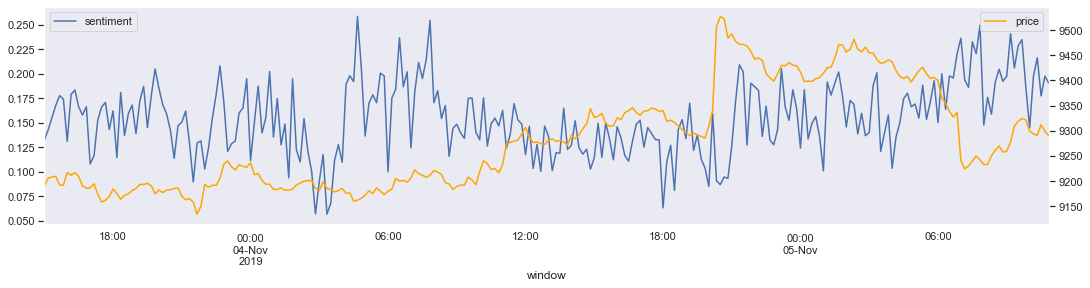

In [8]:
plot_timeline('sentiment', 'price')

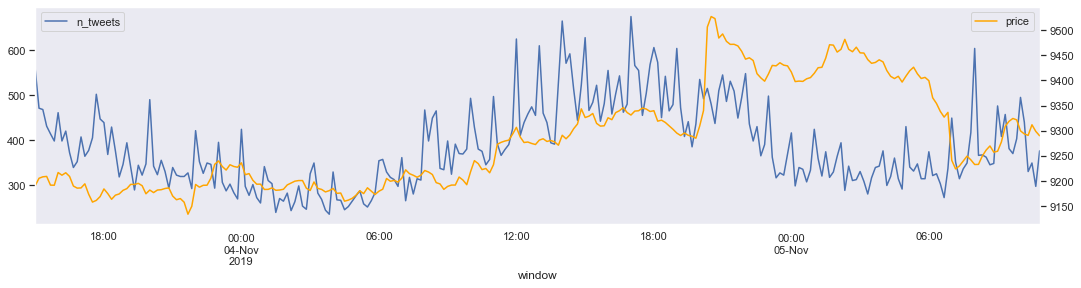

In [9]:
plot_timeline('n_tweets', 'price')

In [30]:
df['target'] = df['price'].shift(-1)
df.head()

,n_tweets,price,sentiment,target
window,,,,
2019-11-03 15:00:00,558,9190.851,0.132156,9205.565
2019-11-03 15:10:00,471,9205.565,0.142665,9208.484
2019-11-03 15:20:00,468,9208.484,0.155131,9209.280
2019-11-03 15:30:00,431,9209.280,0.167685,9191.988
2019-11-03 15:40:00,414,9191.988,0.177687,9191.751


### Train test split

In [17]:
train, test = df.iloc[:200], df.iloc[200:]

### Normalize the data

In [18]:
norm = Normalizer()

train = norm.fit_transform(train)
test = norm.transform(test)

### Transform to supervised learning dataset

In [19]:
train_data_gen = TimeseriesGenerator(train, train,
                               length=12, sampling_rate=1,stride=1,
                               batch_size=3)

test_data_gen = TimeseriesGenerator(test, test,
                               length=12, sampling_rate=1,stride=1,
                               batch_size=1)

### Build the keras model

In [24]:
def generate_model():
    model = Sequential()
    model.add(LSTM(4, input_shape=(12, 3)))
    model.add(Dense(1))
    model.compile(loss='mean_squared_error', optimizer='adam')
    
    return model

In [25]:
model = generate_model()
model.fit_generator(train_data_gen, epochs=10)

Epoch 1/10


ValueError: A target array with shape (3, 3) was passed for an output of shape (None, 1) while using as loss `mean_squared_error`. This loss expects targets to have the same shape as the output.